In [3]:
import cv2
import matplotlib.pyplot as plt
# import pandas as pd
import tensorflow as tf
import keras
import os
import numpy as np
import pandas as pd
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, Dropout, Conv2D, GlobalAveragePooling2D
from tensorflow.keras.models import Model, load_model
from tensorflow.keras import regularizers
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
# from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.models import Sequential
import shutil
PATH = "/mnt/d/Datasets/"
imgPATH = PATH + "mini-DDSM/MINI-DDSM-Complete-PNG-16/"
ddsm_roi_path = PATH + "CBIS-DDSM/ROI/"
cbis_ddsm_data_path = PATH + 'CBIS-DDSM/manifest-ZkhPvrLo5216730872708713142/CBIS-DDSM/'
vindr_roi_path = PATH+"/Vindr-Mammo/ROI/"
data_path = PATH + "mini-DDSM/fullimg/"
save_dir = "/home/jj/FYP/Models/"
combined_path = PATH + "combined/"
full_img_path = '/mnt/d/Datasets/CBIS-DDSM/full_mammogram_image/augmented/'
roi_img_path = '/mnt/d/Datasets/CBIS-DDSM/ROI/augmented/'
image_size = 300
img_height = 300
img_width = 300
batch_size = 16
gpus = tf.config.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

os.environ['TF_ENABLE_GPU_GARBAGE_COLLECTION'] = 'false'
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


# load ddsm

In [4]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  roi_img_path+'train/',
  label_mode="categorical",
  # validation_split=0.2,
  # subset="training",
  seed=42,
  image_size=(img_height, img_width),
  batch_size=batch_size)
  
val_ds = tf.keras.utils.image_dataset_from_directory(
  roi_img_path+'val/',
  label_mode="categorical",
  # validation_split=0.2,
  # subset="validation",
  seed=42,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3100 files belonging to 2 classes.
Found 1870 files belonging to 2 classes.


In [5]:
class_indices = {'class_1': 0, 'class_2': 1}
class_counts = np.zeros((len(class_indices),))
for images, labels in val_ds:
    # print(labels[0])
    for l in labels:
        if l[0] == 1:
            class_counts[0]+=1
        elif l[1] == 1:
            class_counts[1]+=1
        
print('Number of images used from each category:')
for class_name, class_index in class_indices.items():
    print(f'{class_name}: {class_counts[class_index]}')

Number of images used from each category:
class_1: 928.0
class_2: 942.0


In [6]:
preprocessing = preprocess_input
pre_trained = InceptionV3(weights='imagenet', include_top=False, input_shape=(img_height,img_width,3))
pre_trained.trainable = False
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal_and_vertical'),
  tf.keras.layers.RandomRotation((0,0.2),fill_mode='constant'),
  tf.keras.layers.RandomZoom(height_factor=(-0.2,0.2),width_factor=(-0.2,0.2),fill_mode='constant'),
  tf.keras.layers.RandomTranslation(height_factor=(-0.1,0.1),width_factor=(-0.1,0.1),fill_mode='constant')
  ])
#Define model architect
tfinput = Input(shape=(img_height,img_width,3))
data_augment = data_augmentation(tfinput)
pre_process = preprocessing(data_augment)
inceptionv3_model=pre_trained(pre_process,training=False)
# flatten = tf.keras.layers.GlobalAveragePooling2D()(inceptionv3_model)
flatten = tf.keras.layers.Flatten()(inceptionv3_model)
# DO1 = Dropout(0.8)(flatten)
# x = Dense(1024,activation = 'relu')(flatten)
# x = Dense(512,activation='relu')(x)
x = Dense(8,activation = 'relu')(flatten)
x = Dense(8,activation='relu')(x)
x=Dropout(0.5)(x)
# x = Dense(512,activation='relu',kernel_regularizer=regularizers.l2(0.1))(x)
x = Dense(8,activation='relu')(x)
# ,kernel_regularizer=regularizers.l2(0.1))(x)
# output = Dense(1, activation="sigmoid")(DO2)
output = Dense(2, activation="softmax")(x)
model = Model(tfinput,output)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 300, 300, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 300, 300, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 300, 300, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 300, 300, 3)      0         
 a)                                                              
                                                                 
 inception_v3 (Functional)   (None, 8, 8, 2048)        21802784  
                                                                 
 flatten (Flatten)           (None, 131072)            0     

In [7]:
# @tf.function
AUTOTUNE = tf.data.AUTOTUNE
def fetch(data):
    # data=data.cache()
    data = data.batch(4)
    data=data.prefetch(buffer_size=AUTOTUNE)
    return data

In [8]:
train_ds_aug = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds_aug= val_ds.prefetch(buffer_size=AUTOTUNE)

# train_ds_aug = fetch(train_ds)
# val_ds_aug= fetch(val_ds)

In [9]:
class PrintLR(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        lr = tf.keras.backend.get_value(self.model.optimizer.lr)
        print(
            # f'Epoch {epoch}: accuracy={logs["categorical_accuracy"]:.4f}, loss={logs["loss"]:.4f}, '+
            # f'val_accuracy={logs["val_categorical_accuracy"]:.4f}, val_loss={logs["val_loss"]:.4f}, '+
            f' - lr={lr:.7f}')

# initialising

In [10]:
optimiser_Adam = tf.keras.optimizers.Adam(learning_rate=1e-3)
model.compile(
    optimizer= optimiser_Adam,
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=[tf.keras.metrics.CategoricalAccuracy(),tf.keras.metrics.Precision(class_id=0),tf.keras.metrics.Precision(class_id=1)]
    # ,jit_compile=True
)
model.summary()
checkpoint_path = "/home/jj/FYP/Checkpoint/InceptionV3_cbis_ddsm_roi/dense_init_checkpoint/cp-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path, 
    verbose=1, 
    monitor='val_categorical_accuracy',
    save_best_only=True,
    save_weights_only=True,
    save_freq='epoch')

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 300, 300, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 300, 300, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 300, 300, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 300, 300, 3)      0         
 a)                                                              
                                                                 
 inception_v3 (Functional)   (None, 8, 8, 2048)        21802784  
                                                                 
 flatten (Flatten)           (None, 131072)            0     

2023-02-14 22:32:30.495883: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8100
2023-02-14 22:32:33.150681: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.08GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-02-14 22:32:33.150728: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.08GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-02-14 22:32:33.666678: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.06GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if m

193/194 [============================>.] - ETA: 0s - loss: 0.7112 - categorical_accuracy: 0.5301 - precision: 0.5410 - precision_1: 0.5245

2023-02-14 22:33:55.900125: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.04GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-02-14 22:33:55.900177: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.04GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


194/194 [==============================] - ETA: 0s - loss: 0.7110 - categorical_accuracy: 0.5300 - precision: 0.5415 - precision_1: 0.5241

2023-02-14 22:33:56.384143: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.04GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-02-14 22:33:56.384198: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.04GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-02-14 22:34:01.689267: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.06GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-02-14 22:34:01.689315: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU

 - lr=0.0010000
194/194 [==============================] - 102s 455ms/step - loss: 0.7110 - categorical_accuracy: 0.5300 - precision: 0.5415 - precision_1: 0.5241 - val_loss: 0.8517 - val_categorical_accuracy: 0.5235 - val_precision: 0.6209 - val_precision_1: 0.5149
Epoch 2/2
194/194 [==============================] - 42s 214ms/step - loss: 0.6744 - categorical_accuracy: 0.5639 - precision: 0.5988 - precision_1: 0.5479 - val_loss: 0.7812 - val_categorical_accuracy: 0.5818 - val_precision: 0.5471 - val_precision_1: 0.7500
Epoch 3/3
194/194 [==============================] - 41s 211ms/step - loss: 0.6887 - categorical_accuracy: 0.5384 - precision: 0.5289 - precision_1: 0.5545 - val_loss: 0.6698 - val_categorical_accuracy: 0.5679 - val_precision: 0.5359 - val_precision_1: 0.8384
Epoch 4/4
194/194 [==============================] - 42s 214ms/step - loss: 0.6731 - categorical_accuracy: 0.5500 - precision: 0.5316 - precision_1: 0.6083 - val_loss: 0.6589 - val_categorical_accuracy: 0.6326 - v

KeyError: 'val_categorical_accuracy'

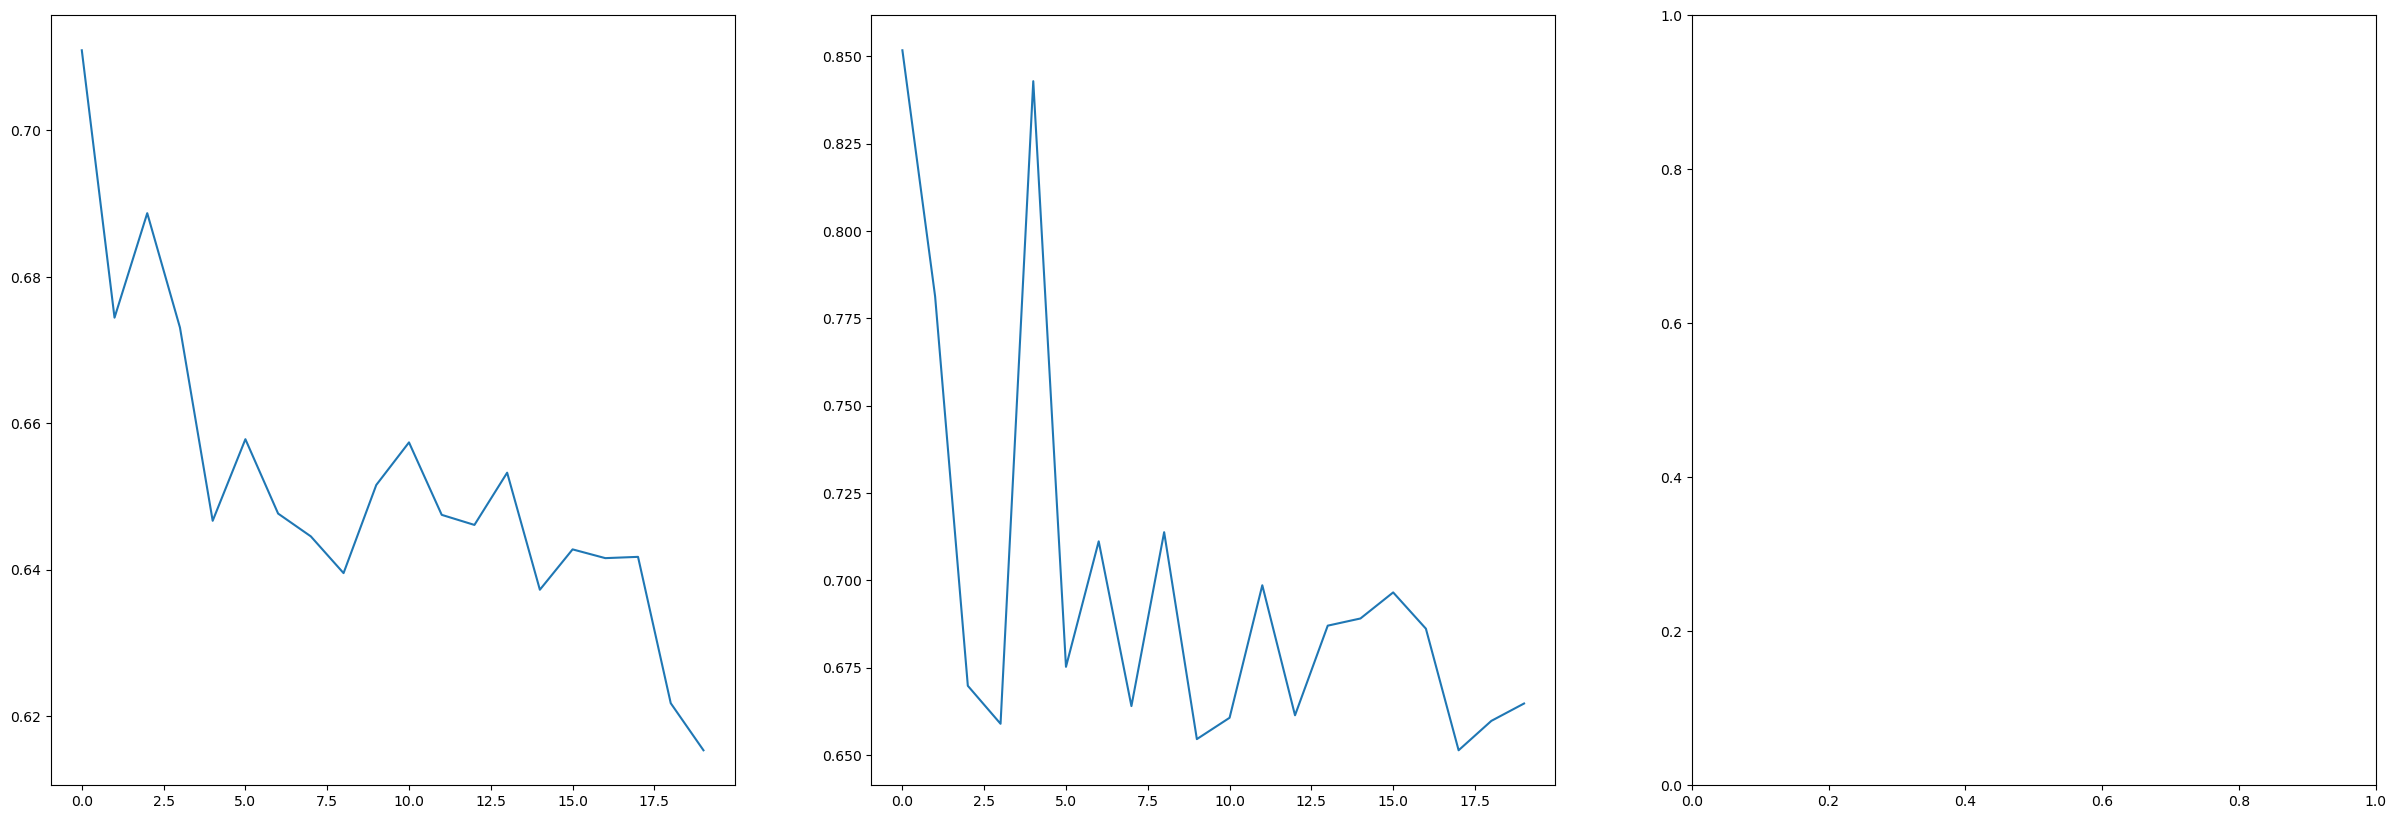

In [11]:
#Training Dense layers to initialise the categoriser before fine tuning the CNN models
best_weights = None
best_val_loss = float('inf')
best_val_acc=float(0)
all_history = {}
all_history['train_loss'] = []
all_history['train_acc'] = []
all_history['val_loss'] = []
all_history['val_acc'] = []
min_lr = 1e-5
with tf.device('/GPU:0'):
    total_epochs=20
    for i in range(total_epochs):
        # print("Epoch: {}".format(i))
        history = model.fit(train_ds_aug
                            ,epochs=i+1
                            ,initial_epoch=i
                            ,validation_data=val_ds_aug
                            ,callbacks = [PrintLR()]
                            # ,verbose=0
                            )
        # print("Learning rate: {}".format(optimiser_Adam.lr.numpy()))
        val_loss = history.history['val_loss'][-1]
        val_categorical_accuracy = history.history['val_categorical_accuracy'][-1]
        loss = history.history['loss'][-1]
        categorical_accuracy = history.history['categorical_accuracy'][-1]
        all_history['train_loss'].append(loss)
        all_history['train_acc'].append(categorical_accuracy)
        all_history['val_loss'].append(val_loss)
        all_history['val_acc'].append(val_categorical_accuracy)
        patience = 20
        # val_improve = val_loss<best_val_loss and
        if val_loss < best_val_loss:
            best_weights = model.get_weights()
            model.save_weights("/home/jj/FYP/Checkpoint/InceptionV3_cbis_ddsm_roi/dense_init_checkpoint/best_model")
            best_val_loss = val_loss
            patience_counter = 0
        else:
            patience_counter += 1

        # Check if we have reached the patience limit
        if patience_counter == patience:
            # Load the best weights back into the model
            model.set_weights(best_weights)
            # Reduce the learning rate
            if optimiser_Adam.lr > min_lr:
                optimiser_Adam.lr = optimiser_Adam.lr * 0.1
            # Reset the patience counter
            patience_counter = 0
# model.save(save_dir + "inceptionv3")
plt.figure(figsize=(30,10))
plt.subplot(131)
plt.plot(all_history['train_loss'])
plt.subplot(132)
plt.plot(all_history['val_loss'])
plt.subplot(133)
plt.plot(all_history['val_acc'])
tf.keras.backend.clear_session()

# fine tuning

In [12]:
preprocessing = preprocess_input
pre_trained = InceptionV3(weights='imagenet', include_top=False, input_shape=(img_height,img_width,3))
pre_trained.trainable = False
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal_and_vertical'),
  tf.keras.layers.RandomRotation((0,0.2),fill_mode='constant'),
  tf.keras.layers.RandomZoom(height_factor=(-0.2,0.2),width_factor=(-0.2,0.2),fill_mode='constant'),
  tf.keras.layers.RandomTranslation(height_factor=(-0.1,0.1),width_factor=(-0.1,0.1),fill_mode='constant')
  ])
#Define model architect
pre_trained.trainable = True
for layer in pre_trained.layers:
  if isinstance(layer, tf.keras.layers.BatchNormalization):
      layer.trainable = False
for layer in pre_trained.layers[:-63]:
  layer.trainable = False
tfinput = Input(shape=(img_height,img_width,3))
data_augment = data_augmentation(tfinput)
pre_process = preprocessing(data_augment)
inceptionv3_model=pre_trained(pre_process,training=False)
# flatten = tf.keras.layers.GlobalAveragePooling2D()(inceptionv3_model)
flatten = tf.keras.layers.Flatten()(inceptionv3_model)
# DO1 = Dropout(0.8)(flatten)
# x = Dense(1024,activation = 'relu')(flatten)
# x = Dense(512,activation='relu')(x)
x = Dense(8,activation = 'relu')(flatten)
x = Dense(8,activation='relu')(x)
x=Dropout(0.5)(x)
# x = Dense(512,activation='relu',kernel_regularizer=regularizers.l2(0.1))(x)
x = Dense(8,activation='relu',kernel_regularizer=regularizers.l2(0.1))(x)
# output = Dense(1, activation="sigmoid")(DO2)
output = Dense(2, activation="softmax")(x)
model_fine = Model(tfinput,output)
model_fine.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 300, 300, 3)]     0         
                                                                 
 sequential_1 (Sequential)   (None, 300, 300, 3)       0         
                                                                 
 tf.math.truediv_1 (TFOpLamb  (None, 300, 300, 3)      0         
 da)                                                             
                                                                 
 tf.math.subtract_1 (TFOpLam  (None, 300, 300, 3)      0         
 bda)                                                            
                                                                 
 inception_v3 (Functional)   (None, 8, 8, 2048)        21802784  
                                                                 
 flatten_1 (Flatten)         (None, 131072)            0   

In [17]:
#load model_fine with best performance
# model_fine.load_weights("/home/jj/FYP/Checkpoint/EfficientNet/dense_init_checkpoint/cp-0010.ckpt")
# tf.keras.backend.clear_session()
latest = tf.train.latest_checkpoint('/home/jj/FYP/Checkpoint/InceptionV3_cbis_ddsm_roi/fine_tuning_checkpoint_loss/')
model_fine.load_weights(latest)
# model_fine.summary()
checkpoint_path = "/home/jj/FYP/Checkpoint/InceptionV3_cbis_ddsm_roi/fine_tuning_checkpoint_loss/cp-{epoch:04d}.ckpt"
# cp_callback_loss = tf.keras.callbacks.ModelCheckpoint(
    # filepath=checkpoint_path, 
    # verbose=1, 
    # monitor='val_loss',
    # save_best_only=True,
    # save_weights_only=True,
    # save_freq='epoch')
checkpoint_path_2 = "/home/jj/FYP/Checkpoint/InceptionV3_cbis_ddsm_roi/fine_tuning_checkpoint_acc/cp-{epoch:04d}.ckpt"
# cp_callback_acc = tf.keras.callbacks.ModelCheckpoint(
    # filepath=checkpoint_path_2, 
    # verbose=1, 
    # monitor='val_categorical_accuracy',
    # save_best_only=True,
    # save_weights_only=True,
    # save_freq='epoch')
optimiser = tf.keras.optimizers.legacy.SGD(learning_rate=0.001)
model_fine.compile(
    optimizer= optimiser,
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=[tf.keras.metrics.CategoricalAccuracy(),tf.keras.metrics.Precision(class_id=0),tf.keras.metrics.Precision(class_id=1)]
)
# reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',factor=0.5,patience=5,min_lr=1e-6,verbose=1)
best_weights = None
best_val_loss = float('inf')
best_val_acc=float(0)
all_history = {}
all_history['train_loss'] = []
all_history['train_acc'] = []
all_history['val_loss'] = []
all_history['val_acc'] = []
min_lr = 1e-7
with tf.device('/GPU:0'):
    total_epochs=300
    for i in range(total_epochs):
        # print("Epoch: {}".format(i))
        history = model_fine.fit(train_ds_aug
                            ,epochs=i+1
                            ,initial_epoch=i
                            ,validation_data=val_ds_aug
                            ,callbacks = [PrintLR()]
                            # ,verbose=0
                            )
        # print("Learning rate: {}".format(optimiser.lr.numpy()))
        val_loss = history.history['val_loss'][-1]
        val_categorical_accuracy = history.history['val_categorical_accuracy'][-1]
        loss = history.history['loss'][-1]
        categorical_accuracy = history.history['categorical_accuracy'][-1]
        all_history['train_loss'].append(loss)
        all_history['train_acc'].append(categorical_accuracy)
        all_history['val_loss'].append(val_loss)
        all_history['val_acc'].append(val_categorical_accuracy)
        patience = 10
        # val_improve = val_loss<best_val_loss and
        if val_loss < best_val_loss:
            best_weights = model_fine.get_weights()
            model_fine.save_weights("/home/jj/FYP/Checkpoint/InceptionV3_cbis_ddsm_roi/fine_tuning_checkpoint_loss/best_model")
            best_val_loss = val_loss
            patience_counter = 0
            earlystop_counter = 0
        else:
            patience_counter += 1
            earlystop_counter +=1
        # Check if we have reached the patience limit
        if patience_counter == patience:
            # Load the best weights back into the model_fine
            model_fine.set_weights(best_weights)
            # Reduce the learning rate
            if optimiser.lr > min_lr:
                optimiser.lr = optimiser.lr * 0.9
            # Reset the patience counter
            patience_counter = 0
        if earlystop_counter == 40:
            print(f'Stopped at Epoch: {i+1}')
            break
        

# model_fine.set_weights(best_weights)
# model_fine.save_weights("/home/jj/FYP/Checkpoint/InceptionV3_cbis_ddsm_roi/fine_tuning_checkpoint_loss/best_model")

plt.figure(figsize=(30,10))
plt.subplot(131)
plt.plot(all_history['train_loss'])
plt.subplot(132)
plt.plot(all_history['val_loss'])
plt.subplot(133)
plt.plot(all_history['val_acc'])
tf.keras.backend.clear_session()

194/194 [==============================] - 50s 224ms/step - loss: 0.5198 - categorical_accuracy: 0.7384 - precision: 0.7244 - precision_1: 0.7539 - val_loss: 0.6113 - val_categorical_accuracy: 0.6519 - val_precision: 0.7004 - val_precision_1: 0.6234
Epoch 2/2
194/194 [==============================] - 43s 221ms/step - loss: 0.5260 - categorical_accuracy: 0.7384 - precision: 0.7381 - precision_1: 0.7386 - val_loss: 0.6259 - val_categorical_accuracy: 0.6417 - val_precision: 0.7201 - val_precision_1: 0.6059
Epoch 3/3
194/194 [==============================] - 42s 218ms/step - loss: 0.5129 - categorical_accuracy: 0.7468 - precision: 0.7400 - precision_1: 0.7538 - val_loss: 0.6411 - val_categorical_accuracy: 0.6283 - val_precision: 0.7560 - val_precision_1: 0.5873
Epoch 4/4
194/194 [==============================] - 43s 220ms/step - loss: 0.5129 - categorical_accuracy: 0.7461 - precision: 0.7329 - precision_1: 0.7607 - val_loss: 0.6330 - val_categorical_accuracy: 0.6310 - val_precision: 0.7

2023-02-14 23:54:46.565097: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at whole_file_read_ops.cc:114 : NOT_FOUND: /mnt/d/Datasets/CBIS-DDSM/ROI/augmented/train/benign/P_00091_LEFT_CC_1_1.png; No such file or directory


 77/194 [==========>...................] - ETA: 23s - loss: 0.4925 - categorical_accuracy: 0.7419 - precision: 0.7183 - precision_1: 0.7732

NotFoundError: Graph execution error:

2 root error(s) found.
  (0) NOT_FOUND:  /mnt/d/Datasets/CBIS-DDSM/ROI/augmented/train/benign/P_00091_LEFT_CC_1_1.png; No such file or directory
	 [[{{node ReadFile}}]]
	 [[IteratorGetNext]]
	 [[model_1/sequential_1/random_rotation_1/loop_body/stateful_uniform/Bitcast_1/pfor/TensorListConcatV2/_134]]
  (1) NOT_FOUND:  /mnt/d/Datasets/CBIS-DDSM/ROI/augmented/train/benign/P_00091_LEFT_CC_1_1.png; No such file or directory
	 [[{{node ReadFile}}]]
	 [[IteratorGetNext]]
0 successful operations.
0 derived errors ignored. [Op:__inference_train_function_379743]

In [14]:
test_ds = tf.keras.utils.image_dataset_from_directory(
  roi_img_path+'test/',
  label_mode="categorical",
  # validation_split=0.2,
  # subset="validation",
  # seed=42,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 610 files belonging to 2 classes.


In [15]:
model_fine.evaluate(test_ds)

39/39 [==============================] - 22s 433ms/step - loss: 0.6638 - categorical_accuracy: 0.6049 - precision_2: 0.7541 - precision_3: 0.5055


[0.663771390914917, 0.6049180030822754, 0.7540983557701111, 0.505464494228363]

# with augment

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 300, 300, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 300, 300, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 300, 300, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 300, 300, 3)      0         
 a)                                                              
                                                                 
 inception_v3 (Functional)   (None, 8, 8, 2048)        21802784  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0     

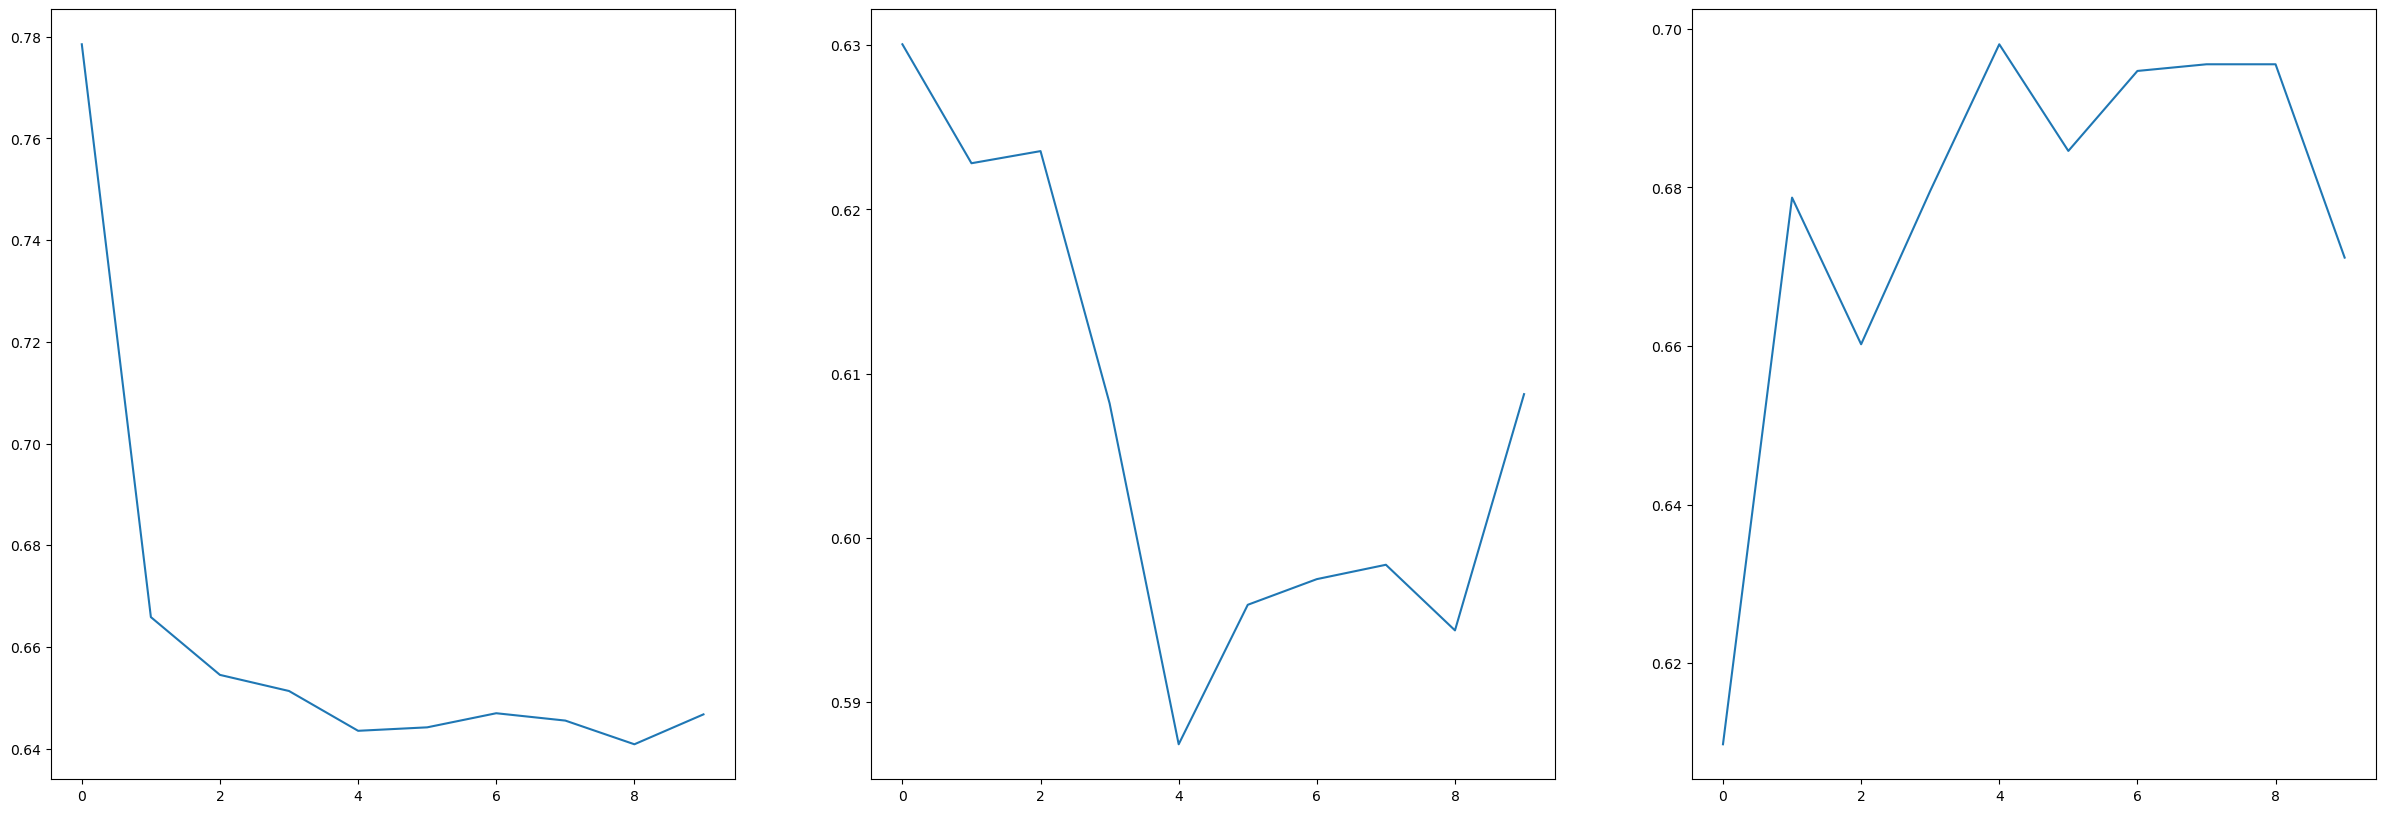

In [ ]:
preprocessing = preprocess_input
pre_trained = InceptionV3(weights='imagenet', include_top=False, input_shape=(img_height,img_width,3))
pre_trained.trainable = False
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal_and_vertical'),
  tf.keras.layers.RandomRotation((0,0.2),fill_mode='constant'),
  tf.keras.layers.RandomZoom(height_factor=(-0.2,0.2),width_factor=(-0.2,0.2),fill_mode='constant'),
  tf.keras.layers.RandomTranslation(height_factor=(-0.1,0.1),width_factor=(-0.1,0.1),fill_mode='constant')
  ])
#Define model_aug architect
tfinput = Input(shape=(img_height,img_width,3))
data_augment = data_augmentation(tfinput,training=True)
pre_process = preprocessing(data_augment)
inceptionv3_model=pre_trained(pre_process,training=False)
# flatten = tf.keras.layers.GlobalAveragePooling2D()(inceptionv3_model)
flatten = tf.keras.layers.Flatten()(inceptionv3_model)
# DO1 = Dropout(0.8)(flatten)
# x = Dense(1024,activation = 'relu')(flatten)
# x = Dense(512,activation='relu')(x)
x = Dense(8,activation = 'relu')(flatten)
x = Dense(8,activation='relu')(x)
x=Dropout(0.5)(x)
# x = Dense(512,activation='relu',kernel_regularizer=regularizers.l2(0.1))(x)
x = Dense(8,activation='relu',kernel_regularizer=regularizers.l2(0.1))(x)
# output = Dense(1, activation="sigmoid")(DO2)
output = Dense(2, activation="softmax")(x)
model_aug = Model(tfinput,output)
model_aug.summary()

model_aug.compile(
    optimizer= tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=[tf.keras.metrics.CategoricalAccuracy(),tf.keras.metrics.Precision(class_id=0),tf.keras.metrics.Precision(class_id=1)]
    # ,jit_compile=True
)
model_aug.summary()
checkpoint_path = "/home/jj/FYP/Checkpoint/InceptionV3_cbis_ddsm_roi_augment/dense_init_checkpoint/cp-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path, 
    verbose=1, 
    monitor='val_categorical_accuracy',
    save_best_only=True,
    save_weights_only=True,
    save_freq='epoch')

#Training Dense layers to initialise the categoriser before fine tuning the CNN mode
with tf.device('/GPU:0'):
    total_epochs = 10
    dense_init = model_aug.fit(train_ds_aug
                        ,epochs=total_epochs
                        ,validation_data=val_ds_aug
                        ,callbacks = [cp_callback]
                        )

# model_aug.save(save_dir + "inceptionv3")
plt.figure(figsize=(30,10))
plt.subplot(131)
plt.plot(dense_init.history['loss'])
plt.subplot(132)
plt.plot(dense_init.history['val_loss'])
plt.subplot(133)
plt.plot(dense_init.history['val_categorical_accuracy'])
tf.keras.backend.clear_session()

In [25]:
# tf.keras.backend.clear_session()
latest = tf.train.latest_checkpoint('/home/jj/FYP/Checkpoint/InceptionV3_cbis_ddsm_roi_augment/dense_init_checkpoint')
model_aug.load_weights(latest)

pre_trained.trainable = True
for layer in pre_trained.layers:
  if isinstance(layer, tf.keras.layers.BatchNormalization):
      layer.trainable = False
for layer in pre_trained.layers[:-63]:
  layer.trainable = False
init_lr = 1e-5
steps = 10000
# final_lr = 1e-6
# lr_schedule = tf.keras.optimizers.schedules.PolynomialDecay( init_lr
                                                            # ,steps
                                                            # ,final_lr
                                                            # ,power=0.5)
model_aug.summary()
checkpoint_path = "/home/jj/FYP/Checkpoint/InceptionV3_cbis_ddsm_roi_augment/fine_tuning_checkpoint_loss/cp-{epoch:04d}.ckpt"
cp_callback_loss = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path, 
    verbose=1, 
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=True,
    save_freq='epoch')
checkpoint_path_2 = "/home/jj/FYP/Checkpoint/InceptionV3_cbis_ddsm_roi_augment/fine_tuning_checkpoint_acc/cp-{epoch:04d}.ckpt"
cp_callback_acc = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path_2, 
    verbose=1, 
    monitor='val_categorical_accuracy',
    save_best_only=True,
    save_weights_only=True,
    save_freq='epoch')
model_aug.compile(
    optimizer= tf.keras.optimizers.legacy.SGD(lr=0.0001),
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=[tf.keras.metrics.CategoricalAccuracy(),tf.keras.metrics.Precision(class_id=0),tf.keras.metrics.Precision(class_id=1)]
)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',factor=0.5,patience=5,min_lr=1e-6,verbose=1)
with tf.device('/GPU:0'):
    total_epochs=50
    history_init = model_aug.fit(train_ds_aug
                        ,epochs=total_epochs
                        # ,initial_epoch=initial_epoch
                        ,validation_data=val_ds_aug
                        ,callbacks = [cp_callback_loss,cp_callback_acc,reduce_lr]
                        )
plt.figure(figsize=(30,10))
plt.subplot(131)
plt.plot(history_init.history['loss'])
plt.subplot(132)
plt.plot(history_init.history['val_loss'])
plt.subplot(133)
plt.plot(history_init.history['val_categorical_accuracy'])
tf.keras.backend.clear_session()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 300, 300, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 300, 300, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 300, 300, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 300, 300, 3)      0         
 a)                                                              
                                                                 
 inception_v3 (Functional)   (None, 8, 8, 2048)        21802784  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0     

In [69]:
with tf.GradientTape() as tape:
  last_conv_layer = model.get_layer('dense_3')
  iterate = tf.keras.models.Model([pre_trained.inputs], [model.output, last_conv_layer.output])
  model_out, last_conv_layer = iterate(x)
  class_out = model_out[:, np.argmax(model_out[0])]
  grads = tape.gradient(class_out, last_conv_layer)
  pooled_grads = tf.keras.backend.K.mean(grads, axis=(0, 1, 2))
  
heatmap = tf.reduce_mean(tf.multiply(pooled_grads, last_conv_layer), axis=-1)

ValueError: Graph disconnected: cannot obtain value for tensor KerasTensor(type_spec=TensorSpec(shape=(None, 300, 300, 3), dtype=tf.float32, name='input_2'), name='input_2', description="created by layer 'input_2'") at layer "sequential". The following previous layers were accessed without issue: []

In [17]:
# Test with different optimiser
# latest = tf.train.latest_checkpoint('/home/jj/FYP/Checkpoint/EfficientNetV2_cbis_ddsm/fine_tuning_checkpoint_acc')
latest = tf.train.latest_checkpoint('/home/jj/FYP/Checkpoint/InceptionV3_cbis_ddsm/fine_tuning_checkpoint_loss')
model.load_weights(latest)
init_lr = 1e-5
steps = 10000
final_lr = 1e-6
lr_schedule = tf.keras.optimizers.schedules.PolynomialDecay( init_lr
                                                            ,steps
                                                            ,final_lr
                                                            ,power=0.5)
model.compile(
    optimizer= tf.keras.optimizers.RMSprop(learning_rate=1e-3),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=[tf.keras.metrics.BinaryAccuracy()]
    # ,jit_compile=True
)
checkpoint_path = "/home/jj/FYP/Checkpoint/InceptionV3_cbis_ddsm/fine_tuning_checkpoint_loss_2/cp-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)
cp_callback_loss = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path, 
    verbose=1, 
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=True,
    save_freq='epoch')
checkpoint_path_2 = "/home/jj/FYP/Checkpoint/InceptionV3_cbis_ddsm/fine_tuning_checkpoint_acc_2/cp-{epoch:04d}.ckpt"
cp_callback_acc = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path_2, 
    verbose=1, 
    monitor='val_binary_accuracy',
    save_best_only=True,
    save_weights_only=True,
    save_freq='epoch')
total_epochs = 100
history_ft_2 = model.fit(train_ds_aug
                    ,epochs=total_epochs
                    # ,initial_epoch=67
                    ,validation_data=val_ds_aug
                    ,callbacks = [cp_callback_loss,cp_callback_acc]
                    )
# model.save(save_dir + "inceptionv3")
plt.figure(figsize=(30,10))
plt.subplot(131)
plt.plot(history_init.history['loss'])
plt.subplot(132)
plt.plot(history_init.history['val_loss'])
plt.subplot(133)
plt.plot(history_init.history['val_binary_accuracy'])

Epoch 1/100
140/140 [==============================] - ETA: 0s - loss: 0.5003 - binary_accuracy: 0.7632WARNING:tensorflow:Model was constructed with shape (300, 300, 3) for input KerasTensor(type_spec=TensorSpec(shape=(300, 300, 3), dtype=tf.float32, name='random_flip_input'), name='random_flip_input', description="created by layer 'random_flip_input'"), but it was called on an input with incompatible shape (None, 300, 300, 3).

Epoch 1: val_loss improved from inf to 0.94284, saving model to /home/jj/FYP/Checkpoint/InceptionV3_cbis_ddsm/fine_tuning_checkpoint_loss_2/cp-0001.ckpt

Epoch 1: val_binary_accuracy improved from -inf to 0.73345, saving model to /home/jj/FYP/Checkpoint/InceptionV3_cbis_ddsm/fine_tuning_checkpoint_acc_2/cp-0001.ckpt
140/140 [==============================] - 39s 236ms/step - loss: 0.5003 - binary_accuracy: 0.7632 - val_loss: 0.9428 - val_binary_accuracy: 0.7335
Epoch 2/100
140/140 [==============================] - ETA: 0s - loss: 0.4968 - binary_accuracy: 0.75

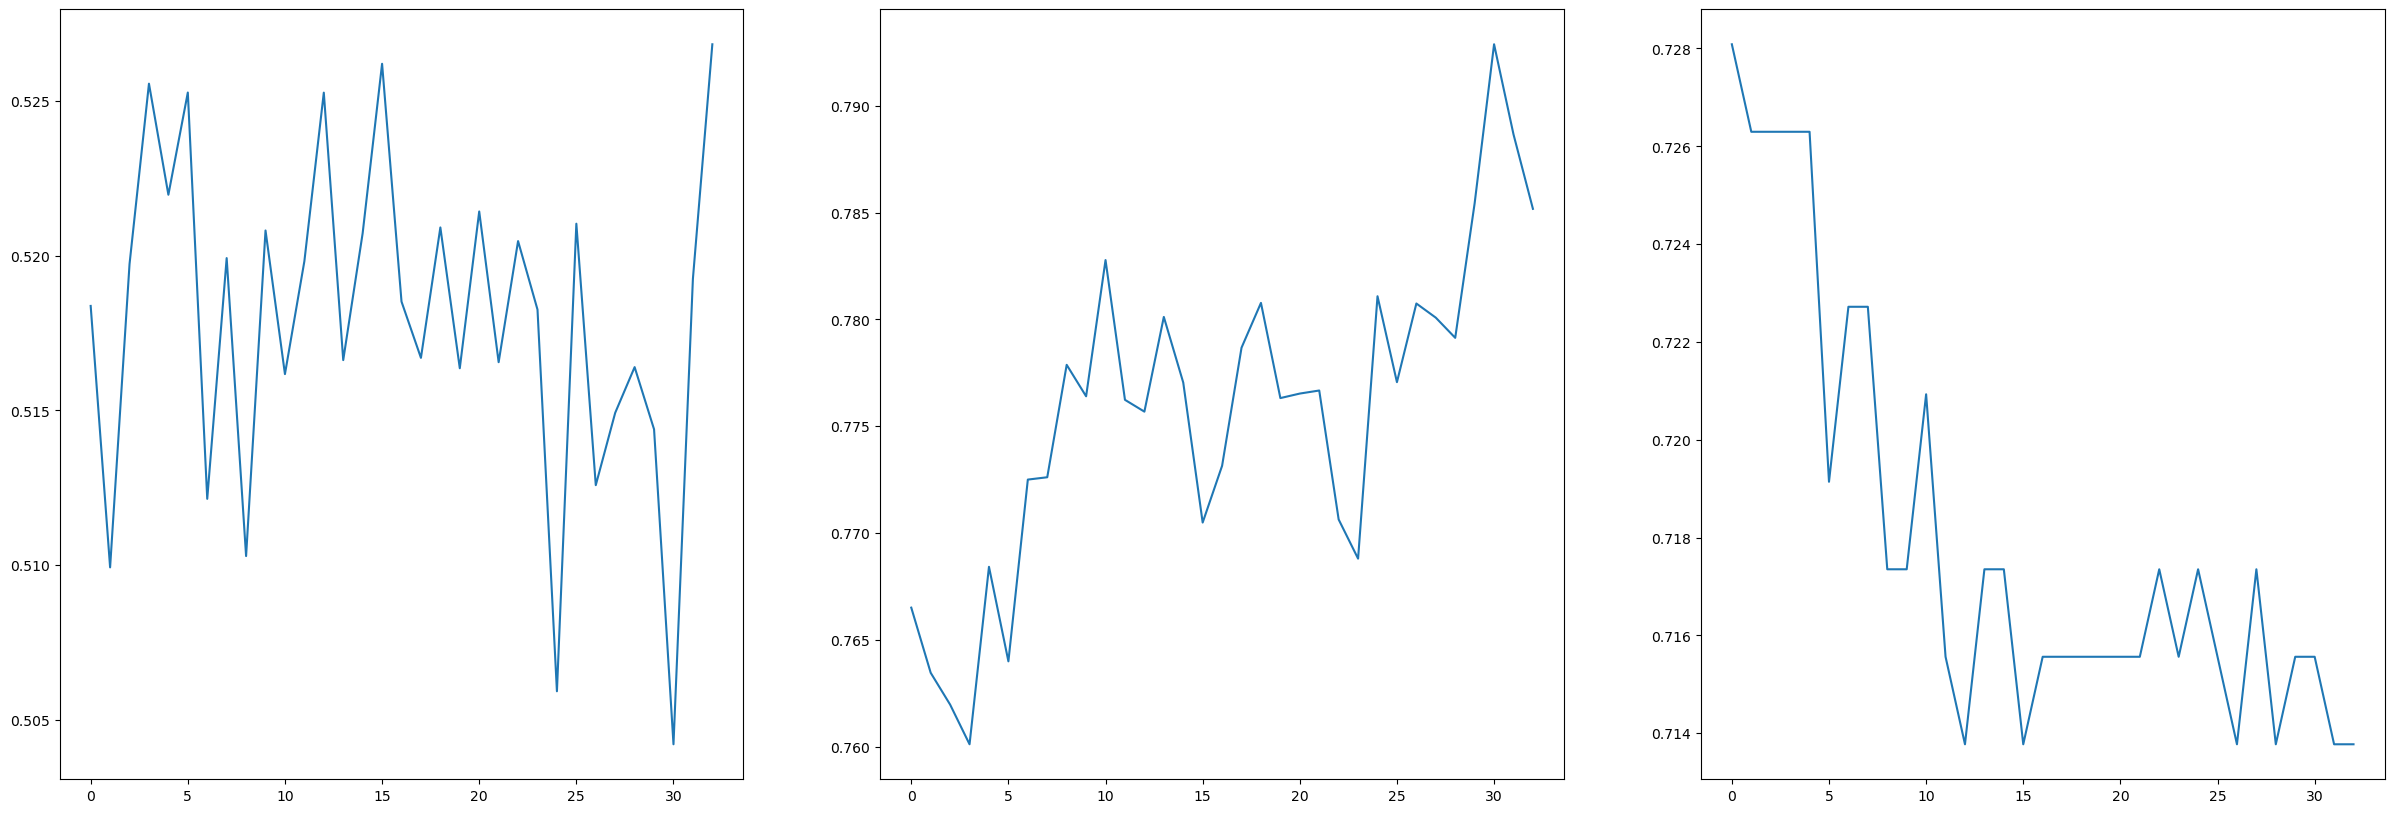

In [16]:
plt.figure(figsize=(30,10))
plt.subplot(131)
plt.plot(history_ft_2.history['loss'])
plt.subplot(132)
plt.plot(history_ft_2.history['val_loss'])
plt.subplot(133)
plt.plot(history_ft_2.history['val_binary_accuracy'])

In [14]:
latest = tf.train.latest_checkpoint('/home/jj/FYP/Checkpoint/EfficientNet_ddsm/fine_tuning_checkpoint_loss')
model.load_weights(latest)
init_lr = 5e-6
steps = 1e5
final_lr = 1e-7
lr_schedule = tf.keras.optimizers.schedules.PolynomialDecay( init_lr
                                                            ,steps
                                                            ,final_lr
                                                            ,power=0.5)
pre_trained.trainable = True
for layer in pre_trained.layers:
  if isinstance(layer, tf.keras.layers.BatchNormalization):
      layer.trainable = False
for layer in pre_trained.layers[:63]:
  layer.trainable = False
model.compile(
    optimizer= tf.keras.optimizers.Adam(learning_rate = 5e-6),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=[tf.keras.metrics.BinaryAccuracy(),tf.keras.metrics.FalsePositives(),tf.keras.metrics.FalseNegatives()]
)
model.summary()
checkpoint_path = "/home/jj/FYP/Checkpoint/EfficientNet_ddsm/full_model_checkpoint_loss/cp-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)
cp_callback_loss = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path, 
    verbose=1, 
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=True,
    save_freq='epoch')
checkpoint_path_2 = "/home/jj/FYP/Checkpoint/EfficientNet_ddsm/full_model_checkpoint_acc/cp-{epoch:04d}.ckpt"
cp_callback_acc = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path_2, 
    verbose=1, 
    monitor='val_binary_accuracy',
    save_best_only=True,
    save_weights_only=True,
    save_freq='epoch')
total_epochs = 100
history_init = model.fit(train_ds_aug
                    ,epochs=total_epochs
                    # ,initial_epoch=38
                    ,validation_data=val_ds_aug
                    ,callbacks = [cp_callback_loss,cp_callback_acc]
                    )
# model.save(save_dir + "inceptionv3")
plt.figure(figsize=(30,10))
plt.subplot(131)
plt.plot(history_init.history['loss'])
plt.subplot(132)
plt.plot(history_init.history['val_loss'])
plt.subplot(133)
plt.plot(history_init.history['val_binary_accuracy'])

ValueError: You are trying to restore a checkpoint from a legacy Keras optimizer into a v2.11+ Optimizer, which can cause errors. Please update the optimizer referenced in your code to be an instance of `tf.keras.optimizers.legacy.Optimizer`, e.g.: `tf.keras.optimizers.legacy.Adam`.

In [ ]:
# for dirName, subdirList, fileList in os.walk('/mnt/c/Users/user/Desktop/CBIS-DDSM/full/'):
#     for fname in fileList:
#         if fname.endswith('.png') and dirName:
#             info = fname.split('_')
#             patient_id = info[1]+ '_' + info[2]
#             mam_type = info[0]
#             view = info[4].split('.')[0]
#             if mam_type =='Calc-Test': 
#                 x = calc_test
#                 train_test = 'test'
#             elif mam_type == 'Calc-Training': 
#                 x = calc_train
#                 train_test = 'train'
#             elif mam_type == 'Mass-Training': 
#                 x = mass_train
#                 train_test = 'train'
#             else: 
#                 x = mass_test
#                 train_test = 'test'
#             for y in x.to_numpy():
#                 if y[0] == patient_id and y[1] == info[3] and y[2] == view:
#                     if y[3] == 'MALIGNANT':
#                         add_type = 'malignant'
#                     else:
#                         add_type = 'benign'
#             shutil.move(dirName+'/'+fname,dirName+train_test+'/'+add_type+'/'+fname)
                